# <center> Week 6: File ingestion and schema validation

## Task

Take any csv/text file of 2+ GB of your choice. --- (You can do this assignment on Google colab)

Read the file ( Present approach of reading the file )

Try different methods of file reading eg: Dask, Modin, Ray, pandas and present your findings in term of computational efficiency

Perform basic validation on data columns : eg: remove special character , white spaces from the col name

As you already know the schema hence create a YAML file and write the column name in YAML file. --define separator of read and write file, column name in YAML

Validate number of columns and column name of ingested file with YAML.

Write the file in pipe separated text file (|) in gz format.

Create a summary of the file:

Total number of rows,

total number of columns

file size

## Dataset

The large dataset, approximately 2.3GB in size, is Recipe Dataset (over 2M) Food. You can find it on https://www.kaggle.com/datasets/wilmerarltstrmberg/recipe-dataset-over-2m

## Load Libraries

In [7]:
import time
import pandas as pd
import dask.dataframe as dd
import modin.pandas as mpd
import ray
import yaml
import os
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Read the file with different methods

In [11]:
file_path = "recipes_data.csv"

In [12]:
# Measure performance of different reading methods
def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

#### Pandas

In [19]:
pandas_df, pandas_time = measure_time(pd.read_csv, file_path)

#chunk_size = 100000
#pandas_df, pandas_time = measure_time(pd.read_csv, file_path, chunksize=chunk_size)

#### Dask

In [15]:
dask_df, dask_time = measure_time(dd.read_csv, file_path)

#### Modin

In [16]:
modin_df, modin_time = measure_time(mpd.read_csv, file_path)

2025-03-09 12:41:52,163	INFO worker.py:1841 -- Started a local Ray instance.


#### Ray

In [17]:
ray_df, ray_time = measure_time(ray.data.read_csv, file_path)

### Compare results

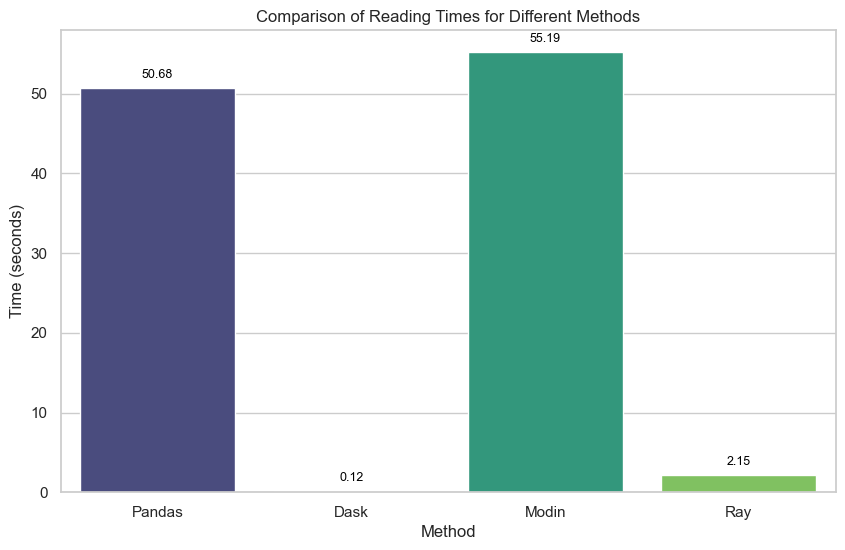

In [24]:
data = {
    'Method': ['Pandas', 'Dask', 'Modin', 'Ray'],
    'Time (seconds)': [pandas_time, dask_time, modin_time, ray_time]
}
df = pd.DataFrame(data)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Method', y='Time (seconds)', data=df, palette='viridis')
plt.title('Comparison of Reading Times for Different Methods')
plt.xlabel('Method')
plt.ylabel('Time (seconds)')
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=9, color='black', 
                      xytext=(0, 5),  
                      textcoords='offset points')

plt.show()

#### Dask demonstrates the fastest computational speed among all methods, making it the superior choice for handling large datasets efficiently

## Cleaning column names

In [25]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True).str.strip()
    return df


In [26]:
pandas_df = clean_column_names(pandas_df)

## Creating YAML file

In [27]:
schema = {
    'separator': ',',
    'columns': list(pandas_df.columns)
}
with open("schema.yaml", "w") as yaml_file:
    yaml.dump(schema, yaml_file)

### Validate column names with YAML

In [28]:
def validate_columns(df, schema_file):
    with open(schema_file, "r") as yaml_file:
        schema = yaml.safe_load(yaml_file)
    return list(df.columns) == schema['columns']


In [29]:
is_valid = validate_columns(pandas_df, "schema.yaml")
print(f"Column validation: {is_valid}")

Column validation: True


### Save file as pipe-separated and gzip compressed

In [30]:
output_file = "processed_dataset.txt.gz"
pandas_df.to_csv(output_file, sep='|', index=False, compression='gzip')


## Summary of file

In [33]:
summary = {
    "Total Rows": len(pandas_df),
    "Total Columns": len(pandas_df.columns),
    "File Size": os.path.getsize(output_file)
}
print(summary)

{'Total Rows': 2231142, 'Total Columns': 7, 'File Size': 642054868}
